# import

In [77]:
import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy.stats import uniform
from scipy.stats import poisson
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import swifter
import ray
from math import sqrt
import math
from copy import copy
from numpy.random import default_rng

# read and add ambient photons
read only fi_orb = 0, tet_orb = 180
ambient approximately 2 times more than number of initial photons

In [58]:
df = pd.read_hdf("./data/Out_fin_pad(200)_x(-1.0,1.0)_E(0.01,10000.0)_eff(0.8)_100.h5")
df1 = pd.read_hdf("./data/Out_fin_pad(200)_x(-1.0,1.0)_E(0.01,10000.0)_eff(0.8)_101.h5")
df.query('a > 3', inplace= True)
df1.query('a > 3', inplace= True)
df1 = df1.query('fi_orb == 0 and tet_orb == 90')
df1.Num = df1.Num + df.loc[len(df) - 1, 'Num'] + 1
df = pd.concat([df, df1], sort=False, ignore_index=True)
df.index = np.arange(len(df))
df['Label'] = 1
df.drop(['inc', 'E0', 'Eg', 'Bp', 'fi_orb', 'tet_orb', 'x0', 'y0', 'z0', 'x_det', 'y_det', 'fi', 'tet'],
axis=1, inplace = True)

In [ ]:
# detect nums event with several Eg == 0
# df1 = df.groupby('Num').apply(lambda x: x.iloc[0]['Num'] if len(x.query('Eg == 0')) > 1 else None)

In [50]:
def delete_duplicate_photons(narr, xarr, yarr):
    narr = np.unique(narr, axis = 1)
    delete_arr = np.array([])
    for i in range(len(narr[0])):
        for j in range(len(xarr)):
            if narr[0][i] == xarr[j] and narr[1][i] == yarr[j]:
                delete_arr = np.append(delete_arr, int(i))
    if (len(delete_arr) == 0):
        return narr
    narr = np.delete(narr, delete_arr.astype(int), axis=1)
    return narr

def add_ambient(df):
    xarr = df.iloc[:]['x_det_pad'].to_numpy()
    yarr = df.iloc[:]['y_det_pad'].to_numpy()
    num_photons = poisson.rvs(mu = 2 * (df.iloc[0]['a'] - 1))
    narr = np.array(
        [uniform.rvs(scale = 199, size = num_photons).astype(int),
        uniform.rvs(scale = 199, size = num_photons).astype(int)]
    )
    narr = delete_duplicate_photons( narr, xarr, yarr )
    df = pd.concat([
        df,
        pd.DataFrame({
            'a' : df.iloc[0]['a'],
            'Z' : df.iloc[0]['Z'],
            'Num' : df.iloc[0]['Num'],
            'x_det_pad' : narr[0],
            'y_det_pad' : narr[1],
            'Label' : 0
        })],
        ignore_index = True
        )
    return df

In [60]:
df = df.swifter.groupby('Num', sort=False).apply(lambda x: add_ambient(x))
df.index = np.arange(len(df))
ray.shutdown()

  0%|          | 0/24 [00:00<?, ?it/s]

# transform dataframe 
simultaneously transform df to this:
1. Num event
2. x (particle coord)
3. y (partcle coord)
4. linreg.coef_ (using "clear" dots)
5. direction (using "clear" dots)
6. linreg.coef_ (using dots from RANSAC)
7. direction (using dots from RANSAC)
8. Z (0 - electron, 1 - positron)

## vars

In [73]:
names_tranform_df = [
    'Num',
    'x',
    'y', 
    'clear_linreg_coeff',
    'clear_direction',
    'dirty_linreg_coeff',
    'dirty_direction',
    'Z'
]
linreg = LinearRegression()
rng = default_rng()

## ransac and small linear regressor classes

In [114]:
class MyException(Exception):
    pass
class RANSAC:
    def __init__(self, n=10, k=100, t=0.05, d=10, model=None, loss=None, metric=None):
        self.n = n              # `n`: Minimum number of data points to estimate parameters
        self.k = k              # `k`: Maximum iterations allowed
        self.t = t              # `t`: Threshold value to determine if points are fit well
        self.d = d              # `d`: Number of close data points required to assert model fits well
        self.model = model      # `model`: class implementing `fit` and `predict`
        self.loss = loss        # `loss`: function of `y_true` and `y_pred` that returns a vector
        self.metric = metric    # `metric`: function of `y_true` and `y_pred` and returns a float
        self.best_fit = None
        self.best_error = np.inf

        self.x_inliner = None
        self.y_inliner = None

    def ray_permut_ids(self, X):
        flag = True
        cnt = 0
        while flag and cnt < 10000:
            cnt+=1
            ids = rng.permutation(np.arange(1, X.shape[0]))
            right = 0
            left = 0
            for i in range(self.n - 1):
                if X[ids[i]][0] > X[0][0]: # TODO what if they lay on one vertical axis?
                    right+=1
                else:
                    left+=1
            if right == 0 or left == 0:
                flag = False
        if flag:
            raise MyException(Exception)
        ids = np.insert(ids, 0, 0)
        return ids

    def is_not_ray_ids(self, X, ids):
        right = 0
        right_arr = []
        left = 0
        left_arr = []
        for i in range(ids.shape[0]):
            if i == 0:
                continue
            if X[ids[i]][0] > X[0][0]: # TODO what if they lay on one vertical axis?
                right+=1
                right_arr.append(i)
            else:
                left+=1
                left_arr.append(i)
        if right > left: # TODO what if they are equal?
            return np.delete(ids, left_arr)
        return np.delete(ids, right_arr)

        

    def fit_logic(self, X, y):
        for _ in range(self.k):
            ids = self.ray_permut_ids(X)

            maybe_inliers = ids[: self.n]

            maybe_model = copy(self.model).fit(X[maybe_inliers], y[maybe_inliers])

            thresholded = (
                self.loss(y[ids][:], maybe_model.predict(X[ids][:]))
                < self.t
            )

            inlier_ids = ids[:][np.flatnonzero(thresholded).flatten()]
            if 0 not in inlier_ids:
                continue
            inlier_ids = self.is_not_ray_ids(X, inlier_ids)

            if inlier_ids.size > self.d:
                inlier_points = inlier_ids 
                better_model = copy(self.model).fit(X[inlier_points], y[inlier_points])

                this_error = self.metric(
                    y[inlier_points], better_model.predict(X[inlier_points])
                )

                if this_error < self.best_error:
                    self.best_error = this_error
                    self.best_fit = better_model
                    i = 0
                    while inlier_points[i] != 0:
                        i+=1
                    inlier_points[[0, i]] = inlier_points[[i, 0]]
                    self.x_inliner = X[inlier_points]
                    self.y_inliner = y[inlier_points]

    def fit(self, X, y):
        sqrt_t = sqrt(self.t)
        self.best_fit = None
        self.best_error = np.inf
        while (self.best_fit == None):
            self.fit_logic(X, y)
            sqrt_t+=1
            self.t = sqrt_t ** 2
        return self

    def predict(self, X):
        return self.best_fit.predict(X)

def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2


def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / y_true.shape[0]


class LinearRegressor:
    def __init__(self):
        self.params = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        r, _ = X.shape
        X = np.hstack([np.ones((r, 1)), X])
        self.params = np.linalg.inv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X: np.ndarray):
        r, _ = X.shape
        X = np.hstack([np.ones((r, 1)), X])
        return X @ self.params

## funcs

In [70]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle(vec):
    x_vec = (1, 0)
    vec = unit_vector(vec)
    return np.arccos(np.clip(np.dot(x_vec, vec), -1.0, 1.0))

def determine_direction(x, y, x0, y0, coef):
    if (coef[0] == 0):
        if (y0 > y):
            return 'left'
        return 'right'
    rad = angle((x0 - x, y0 - y))
    if (rad > math.pi / 2):
        return 'left'
    return 'right'

In [120]:

def clear_transform_logic(df):
    linreg.fit(df.x_det_pad.to_numpy().reshape(-1, 1), df.y_det_pad)
    x = df.iloc[0]['x_det_pad']
    y = df.iloc[0]['y_det_pad']
    x0 = df.iloc[-1]['x_det_pad']
    y0 = linreg.predict(np.array(x0).reshape(-1,1))[0]
    direction = determine_direction(x, y, x0, y0, linreg.coef_)
    return x, y, linreg.coef_[0], direction

def ransac_detect(df):
    regressor = RANSAC(
        n = 4,
        d = 3,
        k=5000,
        t=4,
        model=LinearRegressor(),
        loss=square_error_loss,
        metric=mean_square_error
    )
    regressor.fit(
        df.x_det_pad.to_numpy().reshape(-1, 1),
        df.y_det_pad.to_numpy().reshape(-1, 1)
    )
    _, __, coef, direction = clear_transform_logic(pd.DataFrame({
        'x_det_pad' : regressor.x_inliner.flatten(),
        'y_det_pad' : regressor.y_inliner.flatten()
    }))
    return coef, direction

def transform_df(df):
    x, y, clear_coef, clear_direction = clear_transform_logic(
        df[df.Label == 1]
    )
    try:
        dirty_coef, dirty_direction = ransac_detect(df)
    except MyException:
        dirty_coef = None
        dirty_direction = None
    if df.iloc[0]['Z'] == 1:
        Z = 1
    else:
        Z = 0
    return pd.Series(dict(zip(
        names_tranform_df, [
            df.iloc[0]['Num'],
            x,
            y,
            clear_coef,
            clear_direction,
            dirty_coef,
            dirty_direction,
            Z
        ]
    )))


## transfrom by event number

In [94]:
var = df.groupby('Num').count()
var
ray.shutdown()

(_ray_groupby_apply_chunk pid=1399) 14020.0 [repeated 20x across cluster]


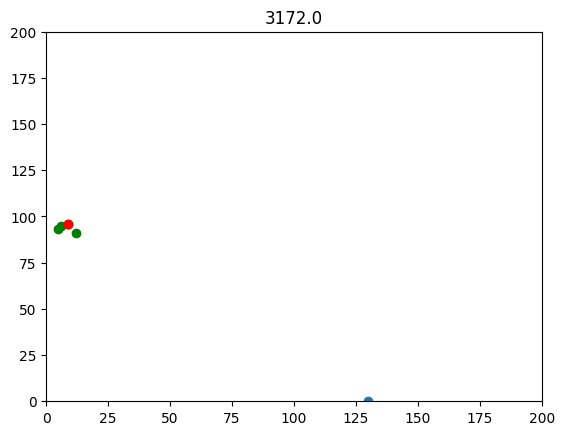

In [105]:
def plot_clear_one_element(df):
    x = df.iloc[0]['x_det_pad']
    y = df.iloc[0]['y_det_pad']
    X = df.x_det_pad.to_numpy().reshape(-1, 1)
    Y = df.y_det_pad.to_numpy().reshape(-1, 1)
    fig, ax = plt.subplots(1, 1)
    plt.xlim(0,200)
    plt.ylim(0,200)
    plt.title(f'{df.iloc[0]["Num"]}')
    # ax.scatter(df[['x_det_pad']], df[['y_det_pad']])
    ax.scatter(df[df.Label == 0][['x_det_pad']], df[df.Label == 0][['y_det_pad']])
    ax.scatter(df[df.Label == 1][['x_det_pad']], df[df.Label == 1][['y_det_pad']], color = 'green')
    ax.scatter([x], [y], facecolor='red')
    plt.show()
plot_clear_one_element(df[df.Num == 3172])

In [122]:
ray.shutdown()
newdf1 = df.query('Num <= 100000').swifter.groupby('Num', sort=False).apply(
    lambda x: transform_df(x)
)

  0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
newdf2 = df.query('Num > 100000 and Num <= 200000').swifter.groupby('Num', sort=False).apply(
    lambda x: transform_df(x)
)

  0%|          | 0/24 [00:00<?, ?it/s]

2024-02-03 00:52:50,842	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(_ray_groupby_apply_chunk pid=1395) 37545.0
(_ray_groupby_apply_chunk pid=1397) 16736.0 [repeated 95x across cluster]
(_ray_groupby_apply_chunk pid=1397) 16748.0 [repeated 87x across cluster]
(_ray_groupby_apply_chunk pid=1399) 12596.0 [repeated 88x across cluster]
(_ray_groupby_apply_chunk pid=1396) 21018.0 [repeated 86x across cluster]
(_ray_groupby_apply_chunk pid=1396) 21029.0 [repeated 74x across cluster]
(_ray_groupby_apply_chunk pid=1401) 8478.0 [repeated 83x across cluster]
(_ray_groupby_apply_chunk pid=1391) 25184.0 [repeated 83x across cluster]
(_ray_groupby_apply_chunk pid=1398) 29352.0 [repeated 74x across cluster]
(_ray_groupby_apply_chunk pid=1402) 4269.0 [repeated 94x across cluster]
(_ray_groupby_apply_chunk pid=1396) 21107.0 [repeated 86x across cluster]
(_ray_groupby_apply_chunk pid=1395) 37646.0 [repeated 67x across cluster]
(_ray_groupby_apply_chunk pid=1394) 41831.0 [repeated 70x across cluster]
(_ray_groupby_apply_chunk pid=1396) 21129.0 [repeated 65x across clust

In [ ]:
newdf3 = df.query('Num > 200000').groupby('Num', sort=False).apply(
    lambda x: transform_df(x)
)